In [37]:
import os
import glob

import numpy as np
import pandas as pd
import xarray as xr

from datetime import time
from shapely.wkt import loads as wkt_loads

In [2]:
def create_TOBAC_mcs_database(mcs_file_seg, TROPICAL_BELT_LAT=(-9, -3), TROPICAL_BELT_LON=(105, 115)):
    
    msc_seg = xr.open_dataset(mcs_file_seg)

    msc_seg_java = msc_seg.where(
        (
            (msc_seg['lat'] > TROPICAL_BELT_LAT[0]) &
            (msc_seg['lat'] < TROPICAL_BELT_LAT[1]) &
            (msc_seg['lon'] > TROPICAL_BELT_LON[0]) &
            (msc_seg['lon'] < TROPICAL_BELT_LON[1]) &
            (
                (msc_seg['time'] < msc_seg['time'][3]) |
                (msc_seg['time'] > msc_seg['time'][11])
            )
        ),
        drop=True
    )

    mcs_unique_ids = np.unique(msc_seg_java.segmentation_mask.values)

    if mcs_unique_ids.shape[0] == 1:
        return False, []

    mcs_ids = mcs_unique_ids[1:]
    
    msc_track = xr.open_dataset(mcs_dir + '/icon_mcs_tracks_' + mcs_file_seg.split('mask')[-1])

    mcs_database = {}

    for id_ in mcs_ids:
        mcs_database[str(int(id_))] = {}
        
        ind_i, ind_j = np.where(msc_track.feature == id_)
        ind_i = ind_i.astype(int)
        ind_j = ind_j.astype(int)
        
        if np.logical_and(
            msc_track.mcs_flag.values[ind_i, ind_j] == 1., np.logical_and(
                msc_track.area.values[ind_i, ind_j] > 1e10,
                msc_track.area.values[ind_i, ind_j] < 25e11)
            ):
            mcs_database[str(int(id_))]['frame_idx'] = [int(ind_i[0]), int(ind_j[0])]
            mcs_database[str(int(id_))]['time'] = msc_track.time.values[int(ind_i[0]), int(ind_j[0])]
            mcs_database[str(int(id_))]['time_str'] = msc_track.timestr.values[int(ind_i[0]), int(ind_j[0])]

            mcs_database[str(int(id_))]['lon'] = msc_track.lon.values[int(ind_i[0]), int(ind_j[0])]
            mcs_database[str(int(id_))]['lat'] = msc_track.lat.values[int(ind_i[0]), int(ind_j[0])]

            mcs_database[str(int(id_))]['max_precip'] = msc_track.max_precip.values[int(ind_i[0]), int(ind_j[0])]
            mcs_database[str(int(id_))]['area'] = msc_track.area.values[int(ind_i[0]), int(ind_j[0])]
            
    return True, mcs_database

In [3]:
mcs_dir = './icon_tobac_msc_tracks'

In [4]:
mcs_file_segs = sorted(glob.glob(os.path.join(mcs_dir, 'icon_mcs_segmentation_mask*')))

In [5]:
 print(mcs_file_segs)

['./icon_tobac_msc_tracks/icon_mcs_segmentation_mask2020-02-01.nc', './icon_tobac_msc_tracks/icon_mcs_segmentation_mask2020-02-02.nc', './icon_tobac_msc_tracks/icon_mcs_segmentation_mask2020-02-03.nc', './icon_tobac_msc_tracks/icon_mcs_segmentation_mask2020-02-04.nc', './icon_tobac_msc_tracks/icon_mcs_segmentation_mask2020-02-05.nc']


In [7]:
mcs_track_database = {}

for mcs_file_seg in mcs_file_segs:
    flag, mcs_database = create_TOBAC_mcs_database(mcs_file_seg)
    print(mcs_file_seg, flag)

    if flag:
        date_ = mcs_file_seg.split('mask')[-1].split('.')[0]
        mcs_track_database[date_] = mcs_database

./icon_tobac_msc_tracks/icon_mcs_segmentation_mask2020-02-01.nc False
./icon_tobac_msc_tracks/icon_mcs_segmentation_mask2020-02-02.nc False
./icon_tobac_msc_tracks/icon_mcs_segmentation_mask2020-02-03.nc True
./icon_tobac_msc_tracks/icon_mcs_segmentation_mask2020-02-04.nc False
./icon_tobac_msc_tracks/icon_mcs_segmentation_mask2020-02-05.nc False


In [ ]:
## MCS TRACKING SCREAMS ##

In [14]:
mcs_catalogue = pd.read_csv('resume_DeepConvection_2020-06-01_2020-08-31.csv')

In [43]:
def get_mcs_init(mcs_catalogue):
    mcs_catalogue['time'] = pd.to_datetime(mcs_catalogue['time'])
    
    # Group by 'belong' and take the first row from each group
    unique_mcs_init = mcs_catalogue.groupby('belong', as_index=False).first()
    
    # Sort the result by datetime
    unique_mcs_init = unique_mcs_init.sort_values(by='time').reset_index(drop=True)

    return unique_mcs_init

In [44]:
unique_mcs_init = get_mcs_init(mcs_catalogue)

In [45]:
def get_mcs_init_local(unique_mcs_init):
    # Filter by time
    unique_mcs_init_local = unique_mcs_init[
        (unique_mcs_init['time'].dt.time < time(3, 0)) |
        (unique_mcs_init['time'].dt.time > time(10, 0))
    ].reset_index(drop=True)

    # Parse WKT to extract lon and lat
    unique_mcs_init_local['geometry'] = unique_mcs_init_local['centroids'].apply(wkt_loads)
    unique_mcs_init_local['centroid_lon'] = unique_mcs_init_local['geometry'].apply(lambda p: p.x)
    unique_mcs_init_local['centroid_lat'] = unique_mcs_init_local['geometry'].apply(lambda p: p.y)
    
    # Filter by lat/lon bounds
    unique_mcs_init_local_geo_filtered = unique_mcs_init_local[
        (unique_mcs_init_local['centroid_lat'] >= -7) & (unique_mcs_init_local['centroid_lat'] <= -3) &
        (unique_mcs_init_local['centroid_lon'] >= 105) & (unique_mcs_init_local['centroid_lon'] <= 115)
    ].reset_index(drop=True)

    return unique_mcs_init_local_geo_filtered

In [46]:
mcs = get_mcs_init_local(unique_mcs_init)

In [47]:
mcs

,belong,id_gdf,time,geometry,area_tb,centroids,pp_10rate,volum_pp,mean_pp,total_duration,centroid_lon,centroid_lat
0,5eb28d27-7fdf,4a9f-917a-08f093eeb1c0,2020-06-01 14:00:00,POINT (112.50000000008797 -5.850000000177383),8284.5,POINT (112.50000000008797 -5.850000000177383),True,False,15.0047,6,112.500000,-5.85
1,dd127b7f-d8f3,4364-9d7a-f94401863384,2020-06-01 17:00:00,POINT (111.49999999968975 -5.850000000627624),11957.7,POINT (111.49999999968975 -5.850000000627624),True,False,16.1843,5,111.500000,-5.85
2,8a9ff667-0a27,4050-8ab6-c4d109f90fe3,2020-06-01 18:00:00,POINT (107.45833333321508 -3.15000000190549),64312.7,POINT (107.45833333321508 -3.15000000190549),True,True,22.3453,6,107.458333,-3.15
3,000301d9-21fa,4f4c-aa5b-55c0921dd0b9,2020-06-02 00:00:00,POINT (114.56428571452412 -5.850000001123254),179924.4,POINT (114.56428571452412 -5.850000001123254),True,True,15.3927,10,114.564286,-5.85
4,d86afebc-72b8,449a-af2d-aafa66341a1c,2020-06-03 16:00:00,POINT (107.8999999974553 -5.749999990882982),9403.9,POINT (107.8999999974553 -5.749999990882982),True,False,16.0638,17,107.900000,-5.75
...,...,...,...,...,...,...,...,...,...,...,...,...
92,804f1a6a-410a,4d5b-b976-aacffece11a8,2020-08-25 16:00:00,POINT (110.0166666666677 -6.750000000008795),2995.2,POINT (110.0166666666677 -6.750000000008795),True,False,33.4030,5,110.016667,-6.75
93,750e0b73-f036,4e67-aa31-3d5a85d56d09,2020-08-26 21:00:00,POINT (108.9900000000064 -6.150000000014787),14018.0,POINT (108.9900000000064 -6.150000000014787),True,True,24.4377,10,108.990000,-6.15
94,114d49ed-5647,49ba-aa43-1881b95a3e68,2020-08-29 01:00:00,POINT (107.5 -4.7500000000061995),3108.7,POINT (107.5 -4.7500000000061995),True,False,9.1107,6,107.500000,-4.75
95,29a490cb-64f6,4f14-af69-51996419be7d,2020-08-29 22:00:00,POINT (108.40000000000188 -5.700000000013637),10588.1,POINT (108.40000000000188 -5.700000000013637),True,True,28.5333,6,108.400000,-5.70


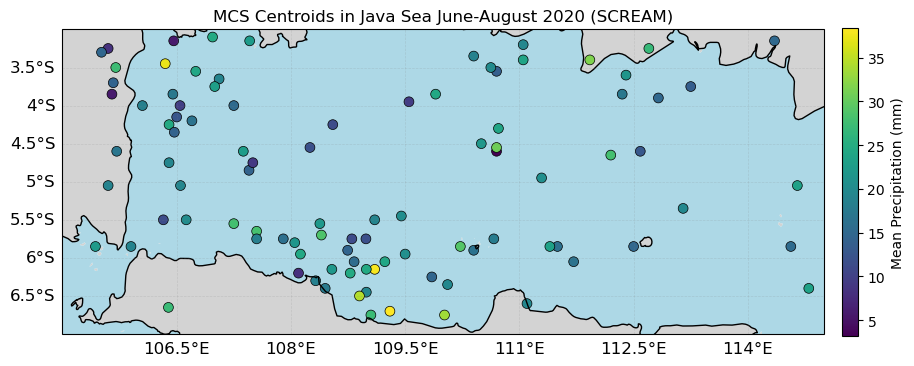

In [55]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Set up the map
fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.PlateCarree())

# Add geographic features
ax.coastlines(resolution='10m')
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
ax.set_extent([105, 115, -7, -3], crs=ccrs.PlateCarree())

# Add gridlines with labels
gl = ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree(),
                  linewidth=0.5, color='gray', alpha=0.2, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 12}
gl.ylabel_style = {'size': 12}

# Scatter plot
sc = ax.scatter(
    mcs['centroid_lon'], mcs['centroid_lat'],
    c=mcs['mean_pp'],
    cmap='viridis',  # You can use 'plasma', 'coolwarm', etc.
    s=50, edgecolor='k', linewidth=0.5,
    transform=ccrs.PlateCarree()
)

# Add colorbar
cbar = plt.colorbar(sc, ax=ax, orientation='vertical', shrink=0.4, pad=0.02)
cbar.set_label('Mean Precipitation (mm)')

# Title and labels
plt.title('MCS Centroids in Java Sea June-August 2020 (SCREAM)')
plt.tight_layout()
plt.show()

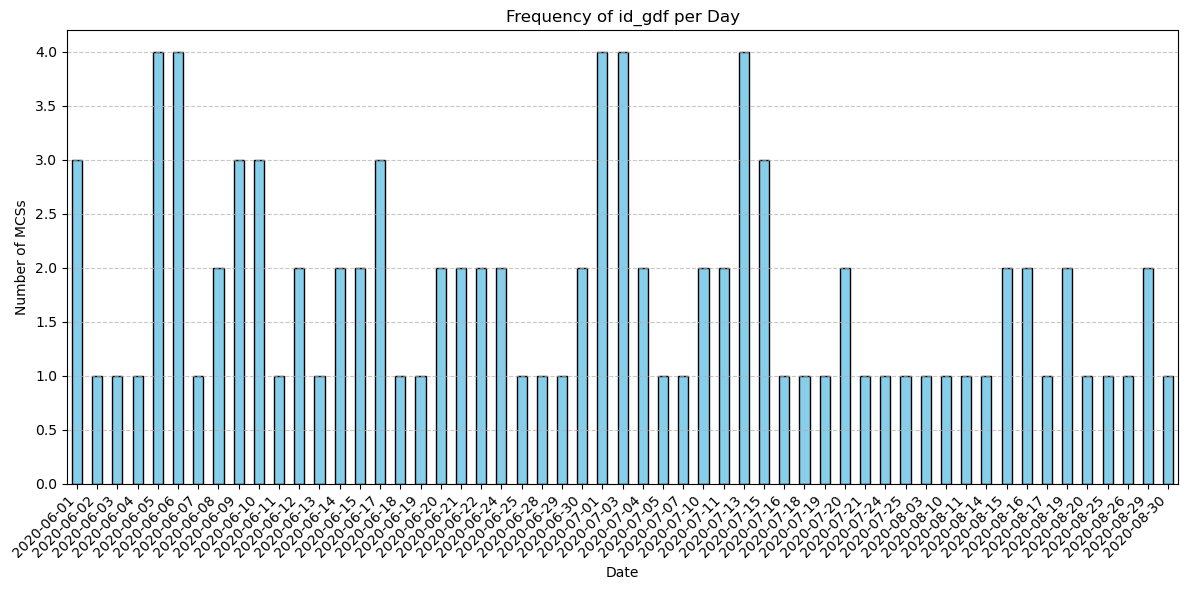

In [67]:
# Extract date part only
mcs['date'] = mcs['time'].dt.date

# Count number of entries per day
daily_counts = mcs.groupby('date')['id_gdf'].count()

# Plot
plt.figure(figsize=(12, 6))
daily_counts.plot(kind='bar', color='skyblue', edgecolor='k')

plt.xlabel('Date')
plt.ylabel('Number of MCSs')
plt.title('Frequency of id_gdf per Day')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig('mcs_daily_frquency.png', dpi=350, bbox_inches='tight')
plt.show()

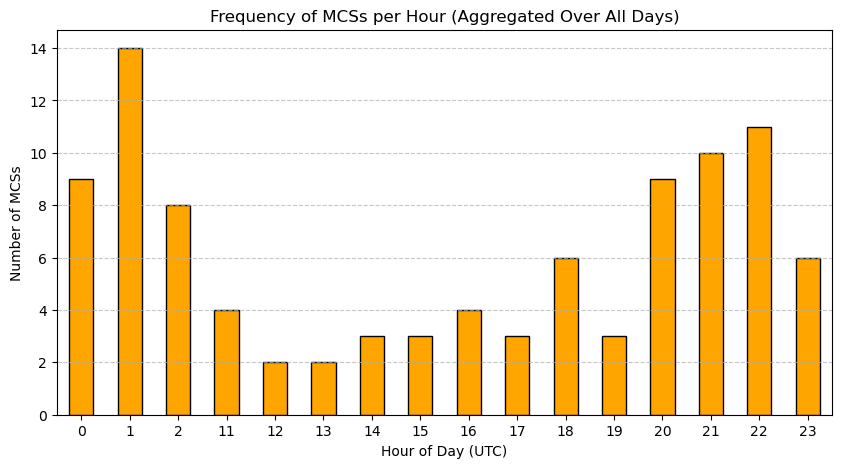

In [68]:
# Extract hour from datetime
mcs['hour'] = mcs['time'].dt.hour

# Count occurrences per hour (aggregated over all days)
hourly_counts = mcs.groupby('hour')['id_gdf'].count()

# Plot
plt.figure(figsize=(10, 5))
hourly_counts.plot(kind='bar', color='orange', edgecolor='k')

plt.xlabel('Hour of Day (UTC)')
plt.ylabel('Number of MCSs')
plt.title('Frequency of MCSs per Hour (Aggregated Over All Days)')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig('mcs_hourly_frquency.png', dpi=350, bbox_inches='tight')
plt.show()